In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import erf
from scipy.sparse import spdiags
from scipy.sparse.linalg import eigsh
import time
import tqdm
from Laplacians import CylinderLaplacian
from poisson_solvers import PoissonCylindrical
from FockMatrices import CylinderFockMatrix

In [10]:
def Verfgau(d, Z=1.0, mu=1.0):
    """
    Args:
    d: d=|r-A| where A is the nucleus position
    Z: nuclear charge
    mu: screening parameter
    """
    c = 0.923 + 1.568 * mu
    alpha = 0.2411 + 1.405 * mu
    long_range = erf(mu * Z * d) / (Z * d)
    return -(Z**2) * (
        c * np.exp(-(alpha**2) * Z**2 * d**2) + long_range
    )

In [11]:
rho_max = 15
drho = 0.1
n_rho = int(rho_max / drho) - 1
rho = np.linspace(0, rho_max, n_rho + 2)
rho_inner = rho[1:-1]

z_max = 15
dz = 0.1
n_z = int(2 * z_max / dz) - 1
z = np.linspace(-z_max, z_max, n_z + 2)
z_inner = z[1:-1]

Laplacian = CylinderLaplacian(rho, z, m=0)
Poisson = PoissonCylindrical(Laplacian, rho, z)

100%|██████████| 9999/9999 [00:19<00:00, 520.55it/s]


Energy imaginary time : -0.49825781
Energy diagonalization: -0.49826612
E_imag-E_diag         : 0.00000832


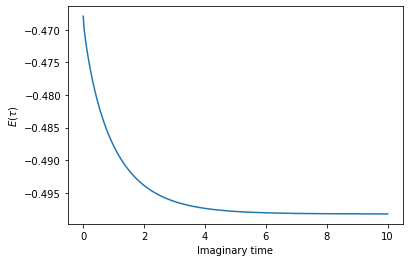

In [12]:
"""
Solve for the Hydrogen atom using imaginary time propagation and compare with exact diagonalization.
"""
V = np.zeros((n_rho, n_z))
psi0 = np.zeros((n_rho, n_z))
# Setup potential and initial guess for the orbitals.
for i in range(n_rho):
    for j in range(n_z):
        r = np.sqrt(rho_inner[i] ** 2 + z_inner[j] ** 2)
        V[i, j] = Verfgau(r, Z=1, mu=1)
        psi0[i, j] = np.sqrt(rho_inner[i]) * np.exp(-0.75 * r)

V = V.flatten()
H = -0.5 * Laplacian.L + spdiags([V], diags=[0])
# Normalize the initial guess.
psi0 = psi0.ravel()
norm_psi0 = np.sum(np.abs(psi0) ** 2) * drho * dz
psi0 /= np.sqrt(norm_psi0)

dt = 0.001
n_t = int(1e4)
imag_time = np.linspace(0, n_t * dt, n_t)

energy = np.zeros(n_t)

for n in tqdm.tqdm(range(n_t - 1)):
    energy[n] = np.sum(psi0 * H.dot(psi0)) * drho * dz
    k1 = -H.dot(psi0)
    k2 = -H.dot(psi0 + 0.5 * dt * k1)
    k3 = -H.dot(psi0 + 0.5 * dt * k2)
    k4 = -H.dot(psi0 + dt * k3)
    psi0 += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    psi0 /= np.sqrt(np.sum(np.abs(psi0) ** 2) * drho * dz)

energy[n_t - 1] = np.sum(psi0 * H.dot(psi0)) * drho * dz

# Solve by diagonalizing the Hamiltonian for comparison with imaginary time propagation.
eps, C = eigsh(H, k=5, which="SA")


print(f"Energy imaginary time : {energy[-1]:.8f}")
print(f"Energy diagonalization: {eps[0]:.8f}")
print(f"E_imag-E_diag         : {np.abs(energy[-1] - eps[0]):.8f}")

plt.figure()
plt.plot(imag_time, energy)
plt.xlabel("Imaginary time")
plt.ylabel(r"$E(\tau)$")
plt.show()

100%|██████████| 9999/9999 [01:43<00:00, 96.36it/s] 


Energy imaginary time : -0.59438627


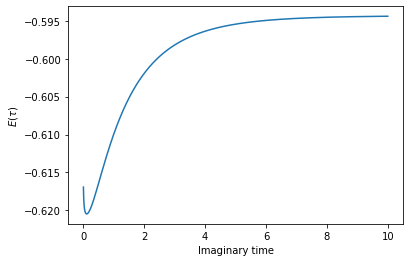

In [13]:
"""
Solve for the H2 molecule with an internuclear distance of 0.7 a.u. using imaginary time propagation.
"""

V_H2 = np.zeros((n_rho, n_z))
V_H2 = np.zeros((n_rho, n_z))
psi_H2 = np.zeros((n_rho, n_z))
Z = 1
dist = 0.7
# Setup potential and initial guess for the orbitals.
for i in range(n_rho):
    for j in range(n_z):
        r_p = np.sqrt(rho_inner[i] ** 2 + (z_inner[j] - dist) ** 2)
        r_m = np.sqrt(rho_inner[i] ** 2 + (z_inner[j] + dist) ** 2)
        V_H2[i, j] = Verfgau(r_p, Z) + Verfgau(r_m, Z)
        psi_H2[i, j] = np.sqrt(rho_inner[i]) * np.exp(-Z * r_p) + np.sqrt(
            rho_inner[i]
        ) * np.exp(-Z * r_m)

V_H2 = V_H2.flatten()
H = -0.5 * Laplacian.L + spdiags([V_H2], diags=[0])

# Normalize the initial guess.
psi_H2 = psi_H2.ravel()
norm_psi_H2 = np.sum(np.abs(psi_H2) ** 2) * drho * dz
psi_H2 /= np.sqrt(norm_psi_H2)

dt = 0.001
n_t = int(1e4)
imag_time = np.linspace(0, n_t * dt, n_t)
energy_H2 = np.zeros(n_t)

# For two-particle systems there is no exchange term.
def _F_psi(psi, W_direct):
    return H.dot(psi) + W_direct * psi


for n in tqdm.tqdm(range(n_t - 1)):
    # Compute direct potential
    P = np.abs(psi_H2) ** 2 / np.sqrt(2 * np.pi)
    P = P.reshape((n_rho, n_z))
    P = np.einsum("i, ij->ij", 1 / rho_inner, P)
    f = -4 * np.pi * np.einsum("i, ij->ij", np.sqrt(rho_inner), P)
    w_ii = Poisson.solve(f, inhomgenous_dirichlet=True)
    W_ii_direct = np.einsum("i, ij->ij", 1 / np.sqrt(rho_inner), w_ii)
    W_direct = W_ii_direct.ravel() / np.sqrt(2 * np.pi)

    F_psi = _F_psi(psi_H2, W_direct)
    energy_H2[n] = np.sum(psi_H2 * F_psi) * drho * dz

    k1 = -F_psi
    k2 = -_F_psi(psi_H2 + 0.5 * dt * k1, W_direct)
    k3 = -_F_psi(psi_H2 + 0.5 * dt * k2, W_direct)
    k4 = -_F_psi(psi_H2 + dt * k3, W_direct)
    psi_H2 += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    psi_H2 /= np.sqrt(np.sum(np.abs(psi_H2) ** 2) * drho * dz)

F_psi = _F_psi(psi_H2, W_direct)
energy_H2[n_t - 1] = np.sum(psi_H2 * F_psi) * drho * dz

print(f"Energy imaginary time : {energy_H2[-1]:.8f}")

plt.figure()
plt.plot(imag_time, energy_H2)
plt.xlabel("Imaginary time")
plt.ylabel(r"$E(\tau)$")
plt.show()

100%|██████████| 9999/9999 [04:16<00:00, 38.95it/s]


Imag time final energy: -0.29522, -2.36165


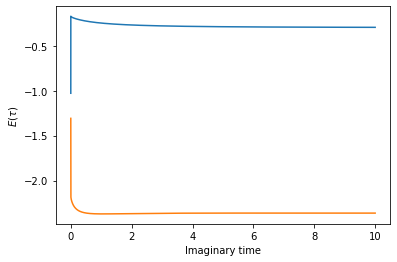

In [14]:
"""
Solve for LiH molecule with an internuclear distance of 1.525 a.u. using imaginary time propagation.
"""

V = np.zeros((n_rho, n_z))
psi0 = np.zeros((n_rho, n_z))
psi1 = np.zeros((n_rho, n_z))
Z1 = 3.0
Z2 = 1.0
dist = 1.525

# Setup potential and initial guess for the orbitals.
for i in range(n_rho):
    for j in range(n_z):
        r_p = np.sqrt(rho_inner[i] ** 2 + (z_inner[j] - dist) ** 2)
        r_m = np.sqrt(rho_inner[i] ** 2 + (z_inner[j] + dist) ** 2)
        V[i, j] = Verfgau(r_p, Z=Z1) + Verfgau(r_m, Z=Z2)
        psi0[i, j] = np.sqrt(rho_inner[i]) * np.exp(-Z1 * r_p)
        psi1[i, j] = np.sqrt(rho_inner[i]) * np.exp(-Z2 * r_m)

V = V.flatten()
Fock = CylinderFockMatrix(Laplacian, V)

##############################################################################
# Orthonormalize the orbitals
Psi = np.zeros((2, n_rho * n_z))
norm_psi0 = np.sum(np.abs(psi0.ravel()) ** 2) * drho * dz
psi0 /= np.sqrt(norm_psi0)

norm_psi1 = np.sum(np.abs(psi1.ravel()) ** 2) * drho * dz
psi1 /= np.sqrt(norm_psi1)

Psi[0] = psi0.ravel()
Psi[1] = psi1.ravel()

S = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        S[i, j] = np.sum(Psi[i].conj() * Psi[j]) * drho * dz
eps, C = np.linalg.eigh(S)
Psi = np.dot(C, Psi)
for i in range(2):
    Psi[i] /= np.sqrt(np.sum(np.abs(Psi[i]) ** 2) * drho * dz)
##############################################################################
dt = 0.001
n_t = int(1e4)
imag_time = np.linspace(0, n_t * dt, n_t)
energy = np.zeros((2, n_t))
##############################################################################

W_direct = np.zeros((2, n_rho * n_z))
for n in tqdm.tqdm(range(n_t - 1)):

    # Compute direct potential
    for i in range(2):
        P = np.abs(Psi[i]) ** 2 / np.sqrt(2 * np.pi)
        P = P.reshape((n_rho, n_z))
        P = np.einsum("i, ij->ij", 1 / rho_inner, P)
        f = -4 * np.pi * np.einsum("i, ij->ij", np.sqrt(rho_inner), P)
        w_ii = Poisson.solve(f, inhomgenous_dirichlet=True)
        W_ii_direct = np.einsum("i, ij->ij", 1 / np.sqrt(rho_inner), w_ii)
        W_direct[i] = W_ii_direct.ravel()

    # Compute exchange potential
    P_10 = Psi[1] * Psi[0] / np.sqrt(2 * np.pi)
    P_10 = P_10.reshape((n_rho, n_z))
    P_10 = np.einsum("i, ij->ij", 1 / rho_inner, P_10)
    f = -4 * np.pi * np.einsum("i, ij->ij", np.sqrt(rho_inner), P_10)
    w_10 = Poisson.solve(f, inhomgenous_dirichlet=False)
    W_10 = np.einsum("i, ij->ij", 1 / np.sqrt(rho_inner), w_10)
    W_10 = W_10.ravel()

    F_psi = Fock.F_Psi(Psi, W_direct, W_10)
    energy[0, n] = np.sum(Psi[0] * F_psi[0]) * drho * dz
    energy[1, n] = np.sum(Psi[1] * F_psi[1]) * drho * dz

    k1 = -F_psi
    k2 = -Fock.F_Psi(Psi + 0.5 * dt * k1, W_direct, W_10)
    k3 = -Fock.F_Psi(Psi + 0.5 * dt * k2, W_direct, W_10)
    k4 = -Fock.F_Psi(Psi + dt * k3, W_direct, W_10)
    Psi += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    S = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            S[i, j] = np.sum(Psi[i].conj() * Psi[j]) * drho * dz
    eps, C = np.linalg.eigh(S)
    Psi = np.dot(C, Psi)
    for i in range(2):
        Psi[i] /= np.sqrt(np.sum(np.abs(Psi[i]) ** 2) * drho * dz)


# Compute direct potential
for i in range(2):
    P = np.abs(Psi[i]) ** 2 / np.sqrt(2 * np.pi)
    P = P.reshape((n_rho, n_z))
    P = np.einsum("i, ij->ij", 1 / rho_inner, P)
    f = -4 * np.pi * np.einsum("i, ij->ij", np.sqrt(rho_inner), P)
    w_ii = Poisson.solve(f, inhomgenous_dirichlet=True)
    W_ii_direct = np.einsum("i, ij->ij", 1 / np.sqrt(rho_inner), w_ii)
    W_direct[i] = W_ii_direct.ravel()

# Compute exchange potential
P_10 = Psi[1] * Psi[0] / np.sqrt(2 * np.pi)
P_10 = P_10.reshape((n_rho, n_z))
P_10 = np.einsum("i, ij->ij", 1 / rho_inner, P_10)
f = -4 * np.pi * np.einsum("i, ij->ij", np.sqrt(rho_inner), P_10)
w_10 = Poisson.solve(f, inhomgenous_dirichlet=False)
W_10 = np.einsum("i, ij->ij", 1 / np.sqrt(rho_inner), w_10)
W_10 = W_10.ravel()

F_psi = Fock.F_Psi(Psi, W_direct, W_10)
energy[0, n_t - 1] = np.sum(Psi[0] * F_psi[0]) * drho * dz
energy[1, n_t - 1] = np.sum(Psi[1] * F_psi[1]) * drho * dz

print(f"Imag time final energy: {energy[0,-1]:.5f}, {energy[1,-1]:.5f}")

plt.figure()
plt.plot(imag_time, energy[0, :])
plt.plot(imag_time, energy[1, :])
plt.xlabel("Imaginary time")
plt.ylabel(r"$E(\tau)$")
plt.show()